<a href="https://www.kaggle.com/code/lukalafaye/gan-mnist-dslab2?scriptVersionId=205561053" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
import os
os.environ['PYTHON_PATH'] = "/kaggle/working/"

In [ ]:
import torch
import os

# Specify the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def D_train(x, G, D, D_optimizer, criterion):
    #======================= Train the discriminator =======================#
    D.zero_grad()

    # Train discriminator on real data
    x_real = x.to(device)
    y_real = torch.ones(x_real.shape[0], 1, device=device)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # Train discriminator on fake data
    z = torch.randn(x_real.shape[0], 100, device=device)  # Latent vector
    x_fake = G(z)
    y_fake = torch.zeros(x_real.shape[0], 1, device=device)

    D_output = D(x_fake)

    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # Gradient backpropagation & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return D_loss.item(), D_real_score, D_fake_score  # Return scores for analysis


def G_train(x, G, D, G_optimizer, criterion):
    #======================= Train the generator =======================#
    G.zero_grad()

    z = torch.randn(x.shape[0], 100, device=device)  # Latent vector
    y = torch.ones(z.shape[0], 1, device=device)  # Target for generator

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # Gradient backpropagation & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.item(), D_output  # Return D_output for analysis


def save_models(G, D, folder):
    os.makedirs(folder, exist_ok=True)  # Ensure the folder exists
    torch.save(G.state_dict(), os.path.join(folder, 'G.pth'))
    torch.save(D.state_dict(), os.path.join(folder, 'D.pth'))


def load_model(model, folder, is_generator=True):
    model_type = 'G' if is_generator else 'D'
    ckpt = torch.load(os.path.join(folder, f'{model_type}.pth'), map_location=device)  # Load model to the correct device
    model.load_state_dict({k.replace('module.', ''): v for k, v in ckpt.items()})
    return model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features * 2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features * 2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))


class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(SanDiscriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features // 2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features // 2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
        
        # Self-attention inspired parameters
        self.attention_weights = nn.Parameter(torch.randn(1, self.fc3.out_features))

    def forward(self, x):
        # Extract features through fully connected layers
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.sigmoid(self.fc4(x))
        return x

In [ ]:
import torch 
import torchvision
import os
import argparse

In [ ]:
args = argparse.Namespace(batch_size=20)  # Set default value

print('Model Loading...')
# Model Pipeline
mnist_dim = 784

model = Generator(g_output_dim = mnist_dim).cuda()
model = load_model(model, '/kaggle/input/g/pytorch/v2/1/')
model = torch.nn.DataParallel(model).cuda()
model.eval()

print('Model loaded.')


print('Start Generating')
os.makedirs('samples', exist_ok=True)

image_paths = []

n_samples = 0
with torch.no_grad():
    while n_samples<10000:
        z = torch.randn(args.batch_size, 100).cuda()
        x = model(z)
        x = x.reshape(args.batch_size, 28, 28)
        for k in range(x.shape[0]):
            if n_samples<10000:
                image_path = os.path.join('samples', f'{n_samples}.png')
                torchvision.utils.save_image(x[k:k+1], image_path)         
                image_paths.append(image_path)  # Store image path
                n_samples += 1

In [ ]:
from IPython.display import display, Image

for img_path in image_paths[:50]:  # Slice to get only the first 10 images
    display(Image(filename=img_path))

In [ ]:
torch.backends.cudnn.benchmark = True

In [ ]:
import torch
import os
from tqdm import trange
import argparse
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from model import Generator, Discriminator
from utils import D_train, G_train, save_models
from IPython.display import display 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

parser = argparse.ArgumentParser(description='Train Normalizing Flow.')
parser.add_argument("--epochs", type=int, default=400, help="Number of epochs for training.")
parser.add_argument("--lr", type=float, default=0.0001, help="The learning rate to use for training.")
parser.add_argument("--batch_size", type=int, default=1024, help="Size of mini-batches for SGD")
args = parser.parse_args(args=[])

os.makedirs('checkpoints', exist_ok=True)
os.makedirs('data', exist_ok=True)

print('Dataset loading...')
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = datasets.MNIST(root='data/MNIST/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='data/MNIST/', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=args.batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=args.batch_size, shuffle=False, num_workers=4, pin_memory=True)
print('Dataset Loaded.')

print('Model Loading...')
mnist_dim = 784
G = torch.nn.DataParallel(Generator(g_output_dim=mnist_dim)).to(device)
D = torch.nn.DataParallel(Discriminator(mnist_dim)).to(device)
print('Model loaded.')

criterion = nn.BCELoss().to(device)
G_optimizer = optim.Adam(G.parameters(), lr=args.lr)
D_optimizer = optim.Adam(D.parameters(), lr=args.lr)

print('Start Training:')

def plot_generated_images(generator, epoch, num_images=20):
    """Function to plot and display generated images from the generator."""
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, 100).to(device)
        generated_images = generator(noise)
        generated_images = generated_images.view(-1, 1, 28, 28).cpu()

        # Create two rows of 10 images
        fig, axes = plt.subplots(2, 10, figsize=(15, 6))
        axes = axes.flatten()  # Flatten the axes array for easy iteration
        for ax, img in zip(axes, generated_images):
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
        plt.tight_layout()
        plt.show()

def plot_losses(G_losses, D_losses):
    """Function to plot the losses over epochs."""
    plt.figure(figsize=(10, 5))
    plt.plot(G_losses, label="Generator Loss")
    plt.plot(D_losses, label="Discriminator Loss")
    plt.title("Generator and Discriminator Losses Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Initialize lists to store the losses
G_losses = []
D_losses = []

n_epoch = args.epochs
for epoch in trange(1, n_epoch + 1, leave=True):
    print(epoch)
    G_loss_epoch = 0
    D_loss_epoch = 0
    
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(-1, mnist_dim).to(device)
        
        D_loss, _, _ = D_train(x, G, D, D_optimizer, criterion)  # Capture only the first return value
        G_loss, _ = G_train(x, G, D, G_optimizer, criterion)  # Capture only the first return value

        # Accumulate the losses for the current epoch
        D_loss_epoch += D_loss
        G_loss_epoch += G_loss

    # Store the average loss per epoch
    D_losses.append(D_loss_epoch / len(train_loader))
    G_losses.append(G_loss_epoch / len(train_loader))

    print(f"Epoch [{epoch}/{n_epoch}], D Loss: {D_losses[-1]:.4f}, G Loss: {G_losses[-1]:.4f}")

    # Save models and generate images every 10 epochs
    if epoch % 10 == 0:
        save_models(G, D, 'checkpoints')
        plot_generated_images(G, epoch)

# After training, plot the losses
plot_losses(G_losses, D_losses)

print('Training done')

In [ ]:
!ls checkpoints

In [ ]:
def save_models(generator, discriminator, epoch, g_losses, d_losses, path='checkpoints'):
    checkpoint = {
        'epoch': epoch,
        'G_state_dict': generator.state_dict(),
        'D_state_dict': discriminator.state_dict(),
        'G_optimizer_state_dict': G_optimizer.state_dict(),
        'D_optimizer_state_dict': D_optimizer.state_dict(),
        'G_losses': g_losses,
        'D_losses': d_losses
    }
    torch.save(checkpoint, os.path.join(path, 'model_checkpoint.pth'))


In [ ]:
save_models(generator, discriminator, epoch, g_losses, d_losses)

In [ ]:
def load_checkpoint(generator, discriminator, g_optimizer, d_optimizer, path='checkpoints/model_checkpoint.pth'):
    checkpoint = torch.load(path)
    generator.load_state_dict(checkpoint['G_state_dict'])
    discriminator.load_state_dict(checkpoint['D_state_dict'])
    g_optimizer.load_state_dict(checkpoint['G_optimizer_state_dict'])
    d_optimizer.load_state_dict(checkpoint['D_optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    g_losses = checkpoint['G_losses']
    d_losses = checkpoint['D_losses']
    return start_epoch, g_losses, d_losses


In [ ]:
# Check if a checkpoint exists to resume from
checkpoint_path = 'checkpoints/model_checkpoint.pth'
if os.path.exists(checkpoint_path):
    print("Loading checkpoint...")
    start_epoch, G_losses, D_losses = load_checkpoint(G, D, G_optimizer, D_optimizer, checkpoint_path)
    print(f"Resuming from epoch {start_epoch}")

In [ ]:
n_epoch=30
for epoch in trange(1, n_epoch + 1, leave=True):
    print(epoch)
    G_loss_epoch = 0
    D_loss_epoch = 0
    
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(-1, mnist_dim).to(device)
        
        D_loss, _, _ = D_train(x, G, D, D_optimizer, criterion)  # Capture only the first return value
        G_loss, _ = G_train(x, G, D, G_optimizer, criterion)  # Capture only the first return value

        # Accumulate the losses for the current epoch
        D_loss_epoch += D_loss
        G_loss_epoch += G_loss

    # Store the average loss per epoch
    D_losses.append(D_loss_epoch / len(train_loader))
    G_losses.append(G_loss_epoch / len(train_loader))

    print(f"Epoch [{epoch}/{n_epoch}], D Loss: {D_losses[-1]:.4f}, G Loss: {G_losses[-1]:.4f}")

    # Save models and generate images every 10 epochs
    if epoch % 10 == 0:
        save_models(G, D, 'checkpoints')
        plot_generated_images(G, epoch)

# After training, plot the losses
plot_losses(G_losses, D_losses)

print('Training done')

In [ ]:
torch.save(G.state_dict(), 'generator2.pth')

In [ ]:
!pip install torch torchvision tqdm matplotlib

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, g_output_dim=784, dim_latent=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

In [11]:
class BaseDiscriminator(nn.Module):
    def __init__(self, input_dim=784):
        super(BaseDiscriminator, self).__init__()
        # Fully connected layers replacing convolutional layers
        self.fc1 = nn.Linear(input_dim, 1024)  # input_dim should match the generator's output dimension
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        # Final classification layer with spectral normalization
        self.fc4 = nn.utils.spectral_norm(nn.Linear(256, 1))
        
        # Class embedding weights
        self.use_class = num_class > 0

        # Class-specific weights for feature scaling
        self.fc_w = nn.Parameter(torch.randn(1, 256))

    def forward(self, x):        
        # Pass input through the fully connected layers
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        h_feature = F.leaky_relu(self.fc3(x), 0.2)
        h_feature = torch.flatten(h_feature, start_dim=1)
        weights = self.fc_w
        out = (h_feature * weights).sum(dim=1)
        return out

# Modified Discriminator Architecture
class SanDiscriminator(BaseDiscriminator):
    def __init__(self, num_class=10):
        super(SanDiscriminator, self).__init__(num_class)

    def forward(self, x, class_ids, flg_train: bool):
        h_feature = self.h_function(x)
        h_feature = torch.flatten(h_feature, start_dim=1)
        weights = self.fc_w[class_ids] if self.use_class else self.fc_w
        direction = F.normalize(weights, dim=1) # Normalize the last layer
        scale = torch.norm(weights, dim=1).unsqueeze(1)
        h_feature = h_feature * scale # For keep the scale
        if flg_train: # for discriminator training
            out_fun = (h_feature * direction.detach()).sum(dim=1)
            out_dir = (h_feature.detach() * direction).sum(dim=1)
            out = dict(fun=out_fun, dir=out_dir)
        else: # for generator training or inference
            out = (h_feature * direction).sum(dim=1)

        return out

In [12]:
import argparse
import json
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tqdm

from torch.utils.data import DataLoader

In [13]:
import os
import json

# Define folder paths
mnist_folder = './data/MNIST'
logs_folder = './logs'
params_path = './hparams/params.json'

# Create folders if they don't exist
os.makedirs(mnist_folder, exist_ok=True)
os.makedirs(logs_folder, exist_ok=True)
os.makedirs(os.path.dirname(params_path), exist_ok=True)

# Define the parameters for params.json
params = {
    "dim_latent": 100,
    "batch_size": 128,
    "learning_rate": 0.001,
    "beta_1": 0.0,
    "beta_2": 0.99,
    "num_epochs": 2
}

# Write parameters to params.json
with open(params_path, 'w') as f:
    json.dump(params, f, indent=4)

print(f"Created folders '{mnist_folder}' and '{logs_folder}', and saved parameters to '{params_path}'.")


Created folders './data/MNIST' and './logs', and saved parameters to './hparams/params.json'.


In [5]:
default_args = {
    "datadir": "./data/MNIST",
    "params": "./hparams/params.json",
    "model": "gan",
    "enable_class": False,
    "logdir": "./logs",
    "device": 0
}


In [14]:
from argparse import Namespace
args = Namespace(**default_args)

print(args.datadir)        # Access './data/MNIST'
print(args.params)         # Access './hparams/params.json'
print(args.model)          # Access 'gan'
print(args.enable_class)   # Access False
print(args.logdir)         # Access './logs'
print(args.device)         # Access 0

./data/MNIST
./hparams/params.json
gan
False
./logs
0


In [18]:
# Train functions

def update_discriminator(x, discriminator, generator, optimizer, params):
    bs = x.size(0)
    device = x.device

    optimizer.zero_grad()

    # for data (ground-truth) distribution
    disc_real = discriminator(x)
    loss_real = eval('compute_loss_'+args.model)(disc_real, loss_type='real')

    # for generator distribution
    latent = torch.randn(bs, params["dim_latent"], device=device)
    img_fake = generator(latent)
    disc_fake = discriminator(img_fake.detach())
    loss_fake = eval('compute_loss_'+args.model)(disc_fake, loss_type='fake')


    loss_d = loss_real + loss_fake
    loss_d.backward()
    optimizer.step()


def update_generator(num_class, discriminator, generator, optimizer, params, device):
    optimizer.zero_grad()

    bs = params['batch_size']
    latent = torch.randn(bs, params["dim_latent"], device=device)

    batch_fake = generator(latent)

    disc_gen = discriminator(batch_fake)
    loss_g = - disc_gen.mean()
    loss_g.backward()
    optimizer.step()


def compute_loss_gan(disc, loss_type):
    assert (loss_type in ['real', 'fake'])
    if 'real' == loss_type:
        loss = (1. - disc).relu().mean() # Hinge loss
    else: # 'fake' == loss_type
        loss = (1. + disc).relu().mean() # Hinge loss

    return loss


def compute_loss_san(disc, loss_type):
    assert (loss_type in ['real', 'fake'])
    if 'real' == loss_type:
        loss_fun = (1. - disc['fun']).relu().mean() # Hinge loss for function h
        loss_dir = - disc['dir'].mean() # Wasserstein loss for omega
    else: # 'fake' == loss_type
        loss_fun = (1. + disc['fun']).relu().mean() # Hinge loss for function h
        loss_dir = disc['dir'].mean() # Wasserstein loss for omega
    loss = loss_fun + loss_dir

    return loss


def save_images(imgs, idx, dirname='test'):
    import numpy as np
    if imgs.shape[1] == 1:
        imgs = np.repeat(imgs, 3, axis=1)
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(10, 10)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(imgs):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.transpose((1,2,0)))

    if not os.path.exists('out/{}/'.format(dirname)):
        os.makedirs('out/{}/'.format(dirname))
    plt.savefig('out/{0}/{1}.png'.format(dirname, str(idx).zfill(3)), bbox_inches="tight")
    plt.close(fig)

hyperparameters: 
	dim_latent: 100
	batch_size: 128
	learning_rate: 0.001
	beta_1: 0.0
	beta_2: 0.99
	num_epochs: 2
epoch: 1/2


  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28])


  2%|▏         | 8/469 [00:01<00:44, 10.36it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


  4%|▍         | 20/469 [00:01<00:17, 25.14it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


  8%|▊         | 39/469 [00:01<00:09, 44.71it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 11%|█         | 52/469 [00:01<00:08, 51.88it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 13%|█▎        | 59/469 [00:01<00:07, 56.21it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 16%|█▌        | 74/469 [00:02<00:06, 62.08it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 19%|█▉        | 88/469 [00:02<00:06, 59.44it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 22%|██▏       | 102/469 [00:02<00:06, 60.34it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 25%|██▍       | 117/469 [00:02<00:05, 62.15it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 28%|██▊       | 131/469 [00:03<00:05, 64.84it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 29%|██▉       | 138/469 [00:03<00:05, 62.50it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 32%|███▏      | 152/469 [00:03<00:05, 62.12it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 36%|███▌      | 167/469 [00:03<00:04, 63.86it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 39%|███▊      | 181/469 [00:03<00:04, 59.66it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 42%|████▏     | 196/469 [00:04<00:04, 61.62it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 43%|████▎     | 204/469 [00:04<00:04, 62.72it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 46%|████▋     | 218/469 [00:04<00:04, 59.41it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 49%|████▉     | 232/469 [00:04<00:03, 62.17it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 53%|█████▎    | 247/469 [00:04<00:03, 61.83it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 54%|█████▍    | 255/469 [00:04<00:03, 66.16it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 57%|█████▋    | 269/469 [00:05<00:03, 63.44it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 61%|██████    | 285/469 [00:05<00:02, 68.19it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 64%|██████▍   | 299/469 [00:05<00:02, 64.76it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 67%|██████▋   | 314/469 [00:05<00:02, 65.81it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 70%|██████▉   | 328/469 [00:06<00:02, 62.39it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 73%|███████▎  | 342/469 [00:06<00:02, 57.65it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 76%|███████▌  | 356/469 [00:06<00:01, 59.12it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 77%|███████▋  | 363/469 [00:06<00:01, 61.50it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 80%|████████  | 377/469 [00:06<00:01, 62.91it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 83%|████████▎ | 391/469 [00:07<00:01, 61.11it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 87%|████████▋ | 406/469 [00:07<00:00, 65.16it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 90%|████████▉ | 420/469 [00:07<00:00, 60.68it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 93%|█████████▎| 434/469 [00:07<00:00, 62.77it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 94%|█████████▍| 442/469 [00:07<00:00, 66.00it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


 97%|█████████▋| 456/469 [00:08<00:00, 61.97it/s]

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


100%|██████████| 469/469 [00:08<00:00, 55.82it/s]


torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([96, 1, 28, 28])


ValueError: axes don't match array

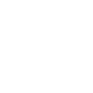

In [23]:
device = f'cuda:{args.device}' if args.device is not None else 'cpu'
model_name = args.model
if not model_name in ['gan', 'san']:
    raise RuntimeError("A model name have to be 'gan' or 'san'.")
    
experiment_name = model_name + "_cond" if args.enable_class else model_name

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,))])

# dataloading
num_class = 10
train_dataset = datasets.MNIST(root=args.datadir, transform=transform, train=True, download=True)
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], num_workers=4,
                          pin_memory=True, persistent_workers=True, shuffle=True)

test_dataset = datasets.MNIST(root=args.datadir, transform=transform, train=False, download=True)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], num_workers=4,
                         pin_memory=True, persistent_workers=True, shuffle=False)

# model
generator = Generator(g_output_dim=784)

if 'gan' == args.model:
    discriminator = BaseDiscriminator(input_dim=784)
    #discriminator = BaseDiscriminator(num_class=num_class if use_class else 0)
else: # 'san' == args.model
    discriminator = SanDiscriminator(num_class=num_class if use_class else 0)
generator = generator.to(device)
discriminator = discriminator.to(device)

# optimizer
betas = (params["beta_1"], params["beta_2"])
optimizer_G = optim.Adam(generator.parameters(), lr=params["learning_rate"], betas=betas)
optimizer_D = optim.Adam(discriminator.parameters(), lr=params["learning_rate"], betas=betas)

ckpt_dir = f'{args.logdir}/{experiment_name}/'
if not os.path.exists(args.logdir):
    os.mkdir(args.logdir)
if not os.path.exists(ckpt_dir):
    os.mkdir(ckpt_dir)

steps_per_epoch = len(train_loader)

msg = ["\t{0}: {1}".format(key, val) for key, val in params.items()]
print("hyperparameters: \n" + "\n".join(msg))

# eval initial states
num_samples_per_class = 10
with torch.no_grad():
    latent = torch.randn(num_samples_per_class * num_class, params["dim_latent"]).cuda()
    imgs_fake = generator(latent)

# main training loop
for n in range(params["num_epochs"]):
    loader = iter(train_loader)

    print("epoch: {0}/{1}".format(n + 1, params["num_epochs"]))
    for i in tqdm.trange(steps_per_epoch):
        x, class_ids = next(loader)
        x = x.to(device)
        x = x.view(x.size(0), -1)

        update_discriminator(x, discriminator, generator, optimizer_D, params)
        update_generator(num_class, discriminator, generator, optimizer_G, params, device)

    torch.save(generator.state_dict(), ckpt_dir + "g." + str(n) + ".tmp")
    torch.save(discriminator.state_dict(), ckpt_dir + "d." + str(n) + ".tmp")

    # eval
    with torch.no_grad():
        latent = torch.randn(num_samples_per_class * num_class, params["dim_latent"]).cuda()
        imgs_fake = generator(latent).cpu().data.numpy()
        save_images(imgs_fake, n, dirname=experiment_name)

torch.save(generator.state_dict(), ckpt_dir + "generator.pt")
torch.save(discriminator.state_dict(), ckpt_dir + "discriminator.pt")

In [ ]:
main(args)